In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Fri Aug 18 17:36:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   30C    P0    63W / 300W |   6890MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [4]:
n_mels = 80
n_outputs = 61
n_frames = 400

### Model

In [8]:
from model.model_glowtts_sid import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256, dilation_rate=2, n_layers=6)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
print('done')

done


### Load

In [9]:
save_dir = '/data/scpark/save/lips/train08.18-1/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 140000, model, None, optimizer)

total 0


### Dataset

In [10]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

train_datasets = []
test_datasets = []

def get_sid(file):
    names = ['No Speaker', 'jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
    for sid, name in enumerate(names):
        if name in file:
            return sid
    return 0

for file in files:
    sid = get_sid(file)
    print(sid, file)
    dataset = LipsDataset(file, n_mels, n_frames, sid=sid, mel=False)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

76
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_10_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_11_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_12_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_2_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_3_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_4_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_5_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_8_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_9_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_10_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
2

In [11]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [12]:
from functools import partial
from data.audio import mel_spectrogram
get_mel = partial(mel_spectrogram, n_fft=2048, num_mels=80, sampling_rate=24000, hop_size=800, win_size=2048, fmin=0, fmax=None, center=False, return_spec=False)
    

test : 0 1.0879364013671875
test : 1 1.095747947692871
test : 2 1.0818746089935303
test : 3 1.0791128873825073
test : 4 1.0742616653442383
test : 5 1.0849759578704834
test : 6 1.0795371532440186
test : 7 1.1057987213134766
test : 8 1.097580075263977
test : 9 1.0911951065063477
test_loss : 1.0878020524978638


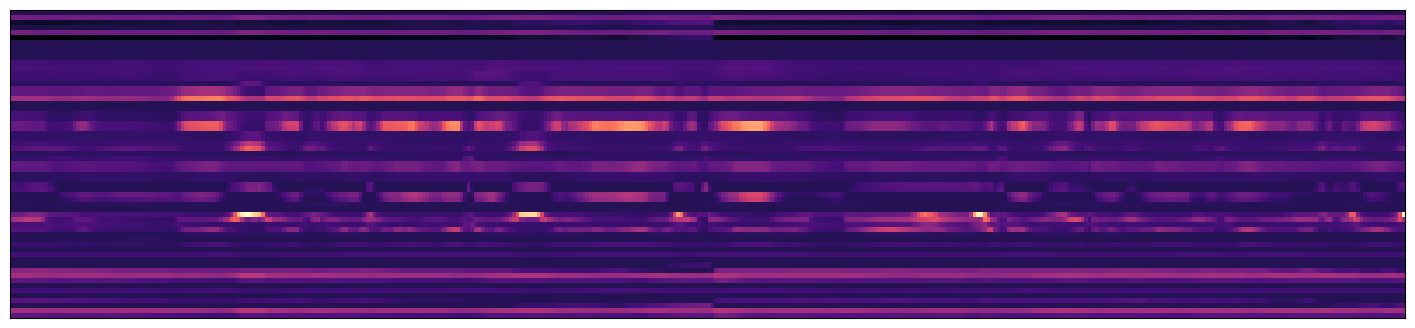

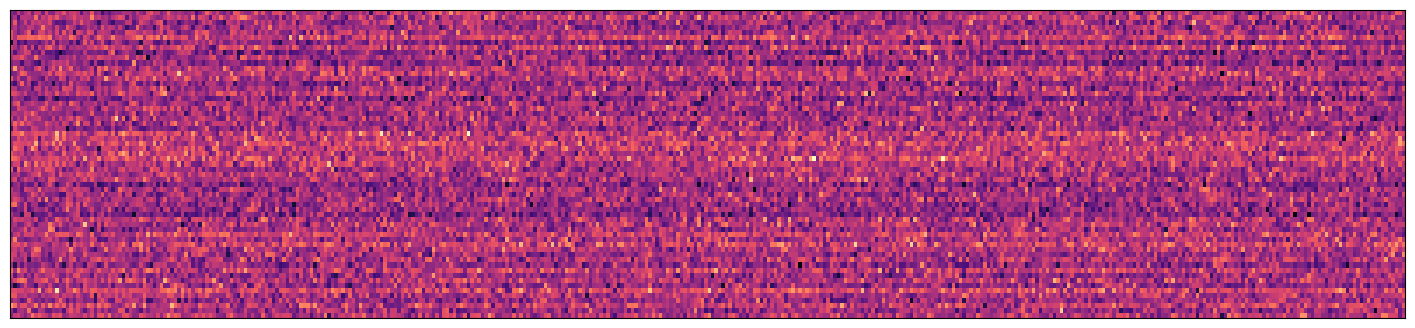

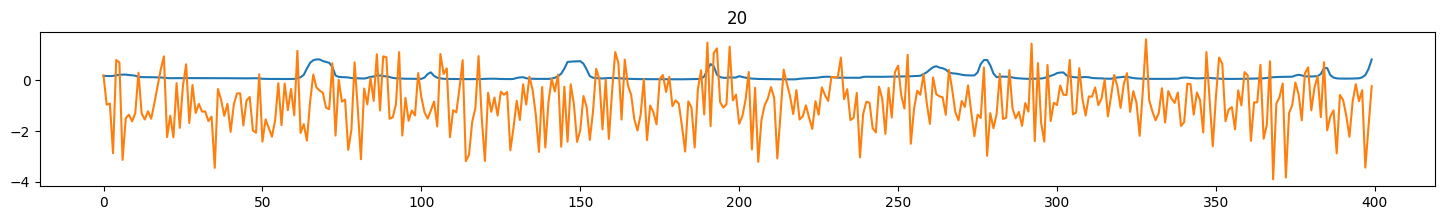

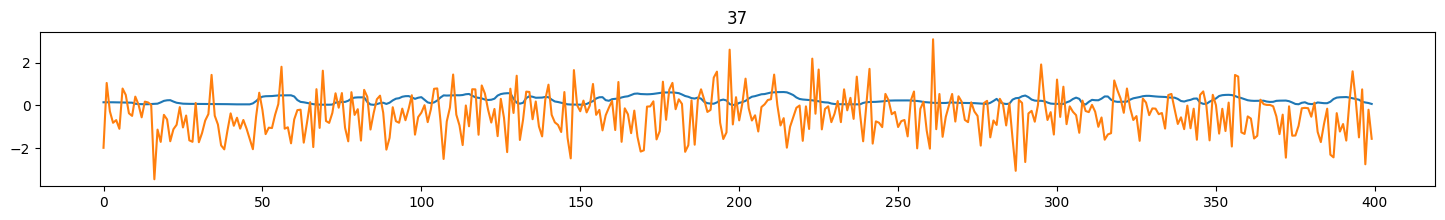

saved /data/scpark/save/lips/train08.18-1/save_0
1
loss 1.0900858640670776
1 1.0900858640670776
2
loss 0.9471877813339233
2 0.9471877813339233
3
loss 0.8730250597000122
3 0.8730250597000122
4
loss 0.8061143159866333
4 0.8061143159866333
5
loss 0.7378149032592773
5 0.7378149032592773
6
loss 0.6688432693481445
6 0.6688432693481445
7
loss 0.6054662466049194
7 0.6054662466049194
8
loss 0.5401769280433655
8 0.5401769280433655
9
loss 0.4738524258136749
9 0.4738524258136749
10
loss 0.41639941930770874
10 0.41639941930770874
11
loss 0.34846240282058716
11 0.34846240282058716
12
loss 0.2990379333496094
12 0.2990379333496094
13
loss 0.24447739124298096
13 0.24447739124298096
14
loss 0.17600834369659424
14 0.17600834369659424
15
loss 0.10454457998275757
15 0.10454457998275757
16
loss 0.0574413537979126
16 0.0574413537979126
17
loss -0.006215155124664307
17 -0.006215155124664307
18
loss -0.07386499643325806
18 -0.07386499643325806
19
loss -0.13885855674743652
19 -0.13885855674743652
20
loss -0.184

160 -2.2177515029907227
161
loss -2.215303421020508
161 -2.215303421020508
162
loss -2.2435998916625977
162 -2.2435998916625977
163
loss -2.1592769622802734
163 -2.1592769622802734
164
loss -2.2070579528808594
164 -2.2070579528808594
165
loss -2.096688747406006
165 -2.096688747406006
166
loss -2.3357415199279785
166 -2.3357415199279785
167
loss -2.0695786476135254
167 -2.0695786476135254
168
loss -2.277169704437256
168 -2.277169704437256
169
loss -2.1792068481445312
169 -2.1792068481445312
170
loss -2.2762680053710938
170 -2.2762680053710938
171
loss -2.2714667320251465
171 -2.2714667320251465
172
loss -2.322171211242676
172 -2.322171211242676
173
loss -2.3025922775268555
173 -2.3025922775268555
174
loss -2.270934581756592
174 -2.270934581756592
175
loss -2.2434682846069336
175 -2.2434682846069336
176
loss -2.3087282180786133
176 -2.3087282180786133
177
loss -2.331056594848633
177 -2.331056594848633
178
loss -2.2798900604248047
178 -2.2798900604248047
179
loss -2.299630641937256
179 -2

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = get_mel(torch.Tensor(batch['wav'])).to(device)
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        sid = torch.Tensor(batch['sid']).int().to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets, sid)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 1000 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 1000 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = get_mel(torch.Tensor(batch['wav'])).to(device)
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                sid = torch.Tensor(batch['sid']).int().to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets, sid)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            model.eval()
            with torch.no_grad():
                y_pred = model.inference(inputs, sid)

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(y_pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(y_pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 10000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)